In [1]:
import pandas as pd
import numpy as np 
import logging
import fastf1
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_style("whitegrid")

In [2]:
fastf1.Cache.enable_cache('./cache')

In [3]:
saudi_race = fastf1.get_session(2025, 'Saudi Arabia Grand Prix', 'R')
saudi_race.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']


In [4]:
def plot_telemetry_channels(telemetry_data: pd.DataFrame, lap_numbers: int | list[int], title: str = "Telemetry Channels vs Distance"):
    """
    Plots available telemetry channels against distance for specified lap(s).

    Args:
        telemetry_data: DataFrame containing car telemetry data with an added 'Distance' column.
                        Must include a 'LapNumber' column.
        lap_numbers: A single lap number (int) or a list of lap numbers (list[int]) to plot.
        title: The main title for the entire plot figure.
    """
    if isinstance(lap_numbers, int):
        lap_numbers = [lap_numbers] # Convert single lap number to a list

    # Identify telemetry channels to plot (exclude time, distance, source, lap number)
    channels_to_plot = [
        col for col in telemetry_data.columns
        if col not in ['Time', 'SessionTime', 'Date', 'Source', 'LapNumber', 'Distance']
    ]

    num_channels = len(channels_to_plot)
    if num_channels == 0:
        print("No telemetry channels found to plot.")
        return

    # Determine grid size for subplots
    cols = 1
    rows = int(np.ceil(num_channels / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True)
    axes = axes.flatten() # Flatten the axes array for easy iteration

    # Plot data for each specified lap and channel
    for i, channel in enumerate(channels_to_plot):
        ax = axes[i]
        for lap_num in lap_numbers:
            lap_data = telemetry_data[telemetry_data['LapNumber'] == lap_num]
            if not lap_data.empty:
                label = f"Lap {lap_num}" if len(lap_numbers) > 1 else None
                ax.plot(lap_data['Distance'], lap_data[channel], label=label)
            else:
                print(f"Warning: No data found for Lap {lap_num}.")

        ax.set_ylabel(channel)
        ax.set_title(f"{channel} vs Distance")
        if len(lap_numbers) > 1:
            ax.legend()
        if i >= num_channels - cols: # Add x-axis label only to bottom row plots
             ax.set_xlabel("Distance (m)")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16, y=1.02) # Add a main title
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

In [5]:
def get_all_car_data(session: fastf1.core.Session, driver: str) -> pd.DataFrame:
    driver_laps = session.laps.pick_drivers(driver).copy()
    driver_laps.loc[:, 'InPit'] = driver_laps['PitOutTime'].notna()
    driver_laps.loc[:, 'OutPit'] = driver_laps['PitInTime'].notna()
    race_car_data = pd.DataFrame()
    for _, lap in driver_laps.iterrows():
        car_data = lap.get_car_data()
        car_data = car_data.add_distance()
        car_data['LapNumber'] = lap.LapNumber
        car_data['LapNumber'] = car_data['LapNumber'].astype(int)
        car_data['Position'] = lap.Position
        car_data['OutPit'] = car_data['LapNumber'].isin(driver_laps[driver_laps['OutPit'] == True]['LapNumber'])
        car_data['InPit'] = car_data['LapNumber'].isin(driver_laps[driver_laps['InPit'] == True]['LapNumber'])
        car_data['Driver'] = driver
        car_data['Session'] = session.name
        car_data['TyreCompound'] = lap.Compound
        car_data['TyreLife'] = lap.TyreLife
        # car_data['Acceleration'] = np.gradient(car_data.Speed/3.6)  incorrect implementation, 
        # because speed is not linear in time
        time_seconds = car_data['Time'].dt.total_seconds()
        car_data['Acceleration(m/s^2)'] = np.gradient(car_data.Speed/3.6, time_seconds)
        race_car_data = pd.concat([race_car_data, car_data])
    return race_car_data

In [9]:
saudi_max_telemetry = get_all_car_data(saudi_race, 'STR')

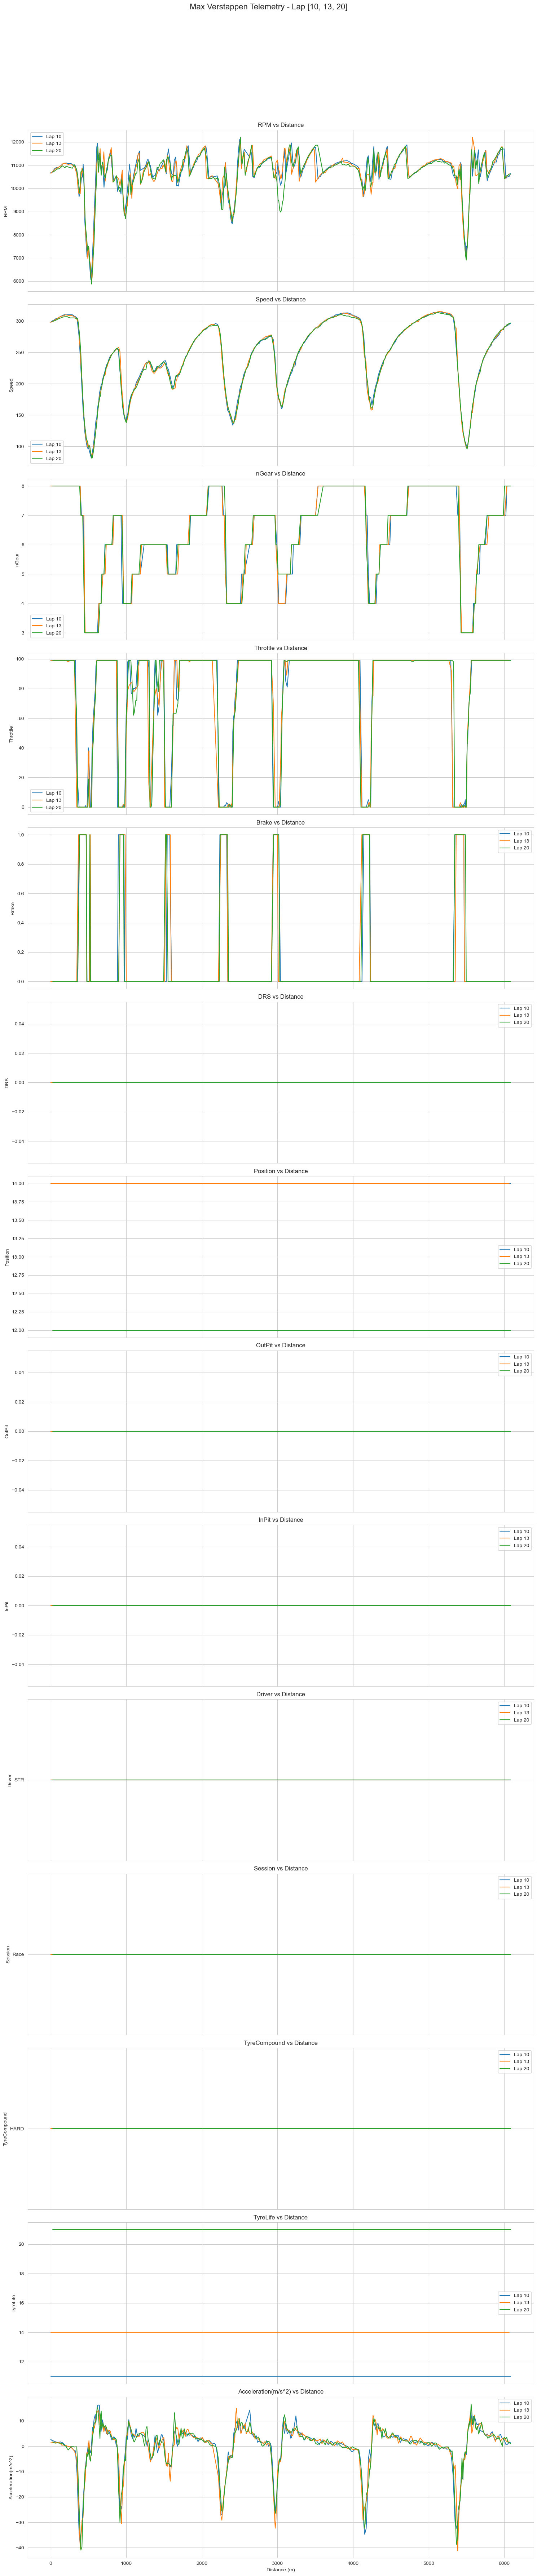

In [10]:
lap_numbers = [10, 13, 20]
plot_telemetry_channels(saudi_max_telemetry, lap_numbers, title=f"Max Verstappen Telemetry - Lap {lap_numbers}")